In [88]:
import os
import yaml
from torch.utils.data import DataLoader
import argparse

from GeospatialFM.data import get_datasets
from GeospatialFM.models import *
# from utils import load_config
from torchgeo.samplers import RandomGeoSampler
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

from transformers import TrainingArguments, Trainer
from transformers import AdamW, get_linear_schedule_with_warmup
from GeospatialFM.utils import setup, get_eval_meter, get_data, init_distributed_device
from GeospatialFM.data import *
from GeospatialFM.models import *
from GeospatialFM.loss import *

from sklearn.linear_model import LogisticRegression
from tqdm import tqdm
import numpy as np
from torch.utils.data import ConcatDataset
import segmentation_models_pytorch as smp
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def unwrap_model(state_dict):
    new_state_dict = OrderedDict()
    for key, value in state_dict.items():
        new_key = key.replace('module.', '')
        new_state_dict[new_key] = value
    
    return new_state_dict

def norm_image(img):
    img = img - img.min()
    img = img / img.max()
    return img

In [79]:
# exp_name = 'mae_cm_reconall_scratch_allTrain'
# exp_name = 'mae_unidecoder_scratch_allTrain_norwl'
n_spectral_blocks = 4
n_spatial_spectral_blocks = 4
n_spatial_blocks = 4
exp_name = f"mae_cvit_{n_spectral_blocks}-{n_spatial_spectral_blocks}-{n_spatial_blocks}"
# exp_name = "mae_base_cvit"
device = torch.device('cuda:2')
# device = torch.device('cpu')

In [80]:
args = {'exp_name': exp_name,
        'config_file': 'GeospatialFM/configs/pretrain_cvit_v2.yaml',
        'opts': None, 
        'save_config': False,
        'device': 2}
args = argparse.Namespace(**args)
args.debug = True
args.finetune = False
device = init_distributed_device(args)
cfg, _ = setup(args)
cfg.MODEL.OPTICAL.kwargs.spectral_blocks = n_spectral_blocks
cfg.MODEL.OPTICAL.kwargs.sptial_spectral_blocks = n_spatial_spectral_blocks
args

Namespace(exp_name='mae_cvit_4-4-4', config_file='GeospatialFM/configs/pretrain_cvit_v2.yaml', opts=None, save_config=False, device='cuda:2', debug=True, finetune=False, distributed=False, world_size=1, rank=0, local_rank=0)

In [81]:
save_path = os.path.join(cfg.TRAINER['output_dir'], 'final_model.pth')
# save_path = os.path.join(cfg.TRAINER['output_dir'], 'ckpt_epoch10.pth')

model = construct_mae(cfg.MODEL)
state_dict = unwrap_model(torch.load(save_path, map_location='cpu'))
model.load_state_dict(state_dict, strict=False)
model = model.to(device)

# print the number of parameters for model
num_params = sum(p.numel() for p in model.optical_encoder.parameters())
print(f'Number of parameters: {num_params}')

Constructing cvit_p1_base_patch16_224 encoder...
Spectral Blocks: 4	Sptial-Spectral Blocks: 4	Spatial Blocks: 4
Constructing cvit_p1_base_patch16_224 encoder...
Number of parameters: 86792448


In [82]:
data_idx = 41982
data = get_data(cfg)
sample = data['test'].dataloader.dataset[data_idx]
for key in sample:
    sample[key] = sample[key].unsqueeze(0)

Training Dataset: BigEarthNet
Train Set: 393418	 Val Set: 12586	 Test Set: 125866


In [141]:
with torch.no_grad():
    out = model.forward_recon(sample['image'].to(device), sample['radar'].to(device), slice_patch_tokens=(13, 2), channel_mask_ratio=0.5, mask_ratio=0.75)

In [142]:
out.keys()

dict_keys(['optical_cls_token', 'radar_cls_token', 'optical_recon', 'radar_recon', 'optical_mask', 'radar_mask', 'optical_channel_mask'])

In [143]:
sample_idx = 0
rgb_channel = [3, 2, 1]

optical_recon = out['optical_recon'].cpu().numpy()
radar_recon = out['radar_recon'].cpu().numpy()
optical_input = sample['image'].cpu().numpy()
radar_input = sample['radar'].cpu().numpy()
optical_mask = out['optical_mask'].cpu().numpy()
radar_mask = out['radar_mask'].cpu().numpy()
optical_channel_mask = out.get('optical_channel_mask', None)
if optical_channel_mask is not None: 
    optical_channel_mask = optical_channel_mask.reshape(-1, 256, 13)[0, 0]
    optical_channel_mask = optical_channel_mask.cpu().numpy()


vis_optical_mask = optical_mask[sample_idx].reshape(14, 14)
vis_radar_mask = radar_mask[sample_idx].reshape(14, 14)
# scale up the mask from 14x14 to 224x224 in chunks of 16x16
vis_optical_mask = np.repeat(np.repeat(vis_optical_mask, 16, axis=0), 16, axis=1)
vis_radar_mask = np.repeat(np.repeat(vis_radar_mask, 16, axis=0), 16, axis=1)
optical_recon_all = optical_recon[sample_idx].transpose(1, 2, 0)
radar_recon_all = radar_recon[sample_idx].transpose(1, 2, 0)
optical_input = optical_input[sample_idx].transpose(1, 2, 0)
radar_input = radar_input[sample_idx].transpose(1, 2, 0)

if optical_recon_all.shape[2] >= 13:
    vis_optical_recon_o = optical_recon_all[:, :, rgb_channel]
else:
    vis_optical_recon_o = None

if optical_recon_all.shape[2] > 13:
    vis_optical_recon_r = optical_recon_all[:, :, 13]
elif optical_recon_all.shape[2] == 13:
    vis_optical_recon_r = None
else:
    vis_optical_recon_r = optical_recon_all[:, :, 0]

if radar_recon_all.shape[2] >= 13:
    vis_radar_recon_o = radar_recon_all[:, :, rgb_channel]
else:
    vis_radar_recon_o = None

if radar_recon_all.shape[2] > 13:
    vis_radar_recon_r = radar_recon_all[:, :, 13]
elif radar_recon_all.shape[2] == 13:
    vis_radar_recon_r = None
else:
    vis_radar_recon_r = radar_recon_all[:, :, 0]

vis_optical_input = optical_input[:, :, rgb_channel]
vis_radar_input = radar_input[:, :, 0]

if vis_optical_recon_o is not None:
    vis_optical_recon_o = vis_optical_recon_o * vis_optical_mask[:, :, None] + vis_optical_input * (1 - vis_optical_mask[:, :, None])
if vis_optical_recon_r is not None:
    vis_optical_recon_r = vis_optical_recon_r * vis_optical_mask + vis_radar_input * (1 - vis_optical_mask)
if vis_radar_recon_o is not None:
    vis_radar_recon_o = vis_radar_recon_o * vis_radar_mask[:, :, None] + vis_optical_input * (1 - vis_radar_mask[:, :, None])
if vis_radar_recon_r is not None:
    vis_radar_recon_r = vis_radar_recon_r * vis_radar_mask + vis_radar_input * (1 - vis_radar_mask)

# normalize all images
vis_optical_recon_o = norm_image(vis_optical_recon_o) if vis_optical_recon_o is not None else None
vis_optical_input = norm_image(vis_optical_input)
vis_radar_recon_o = norm_image(vis_radar_recon_o) if vis_radar_recon_o is not None else None


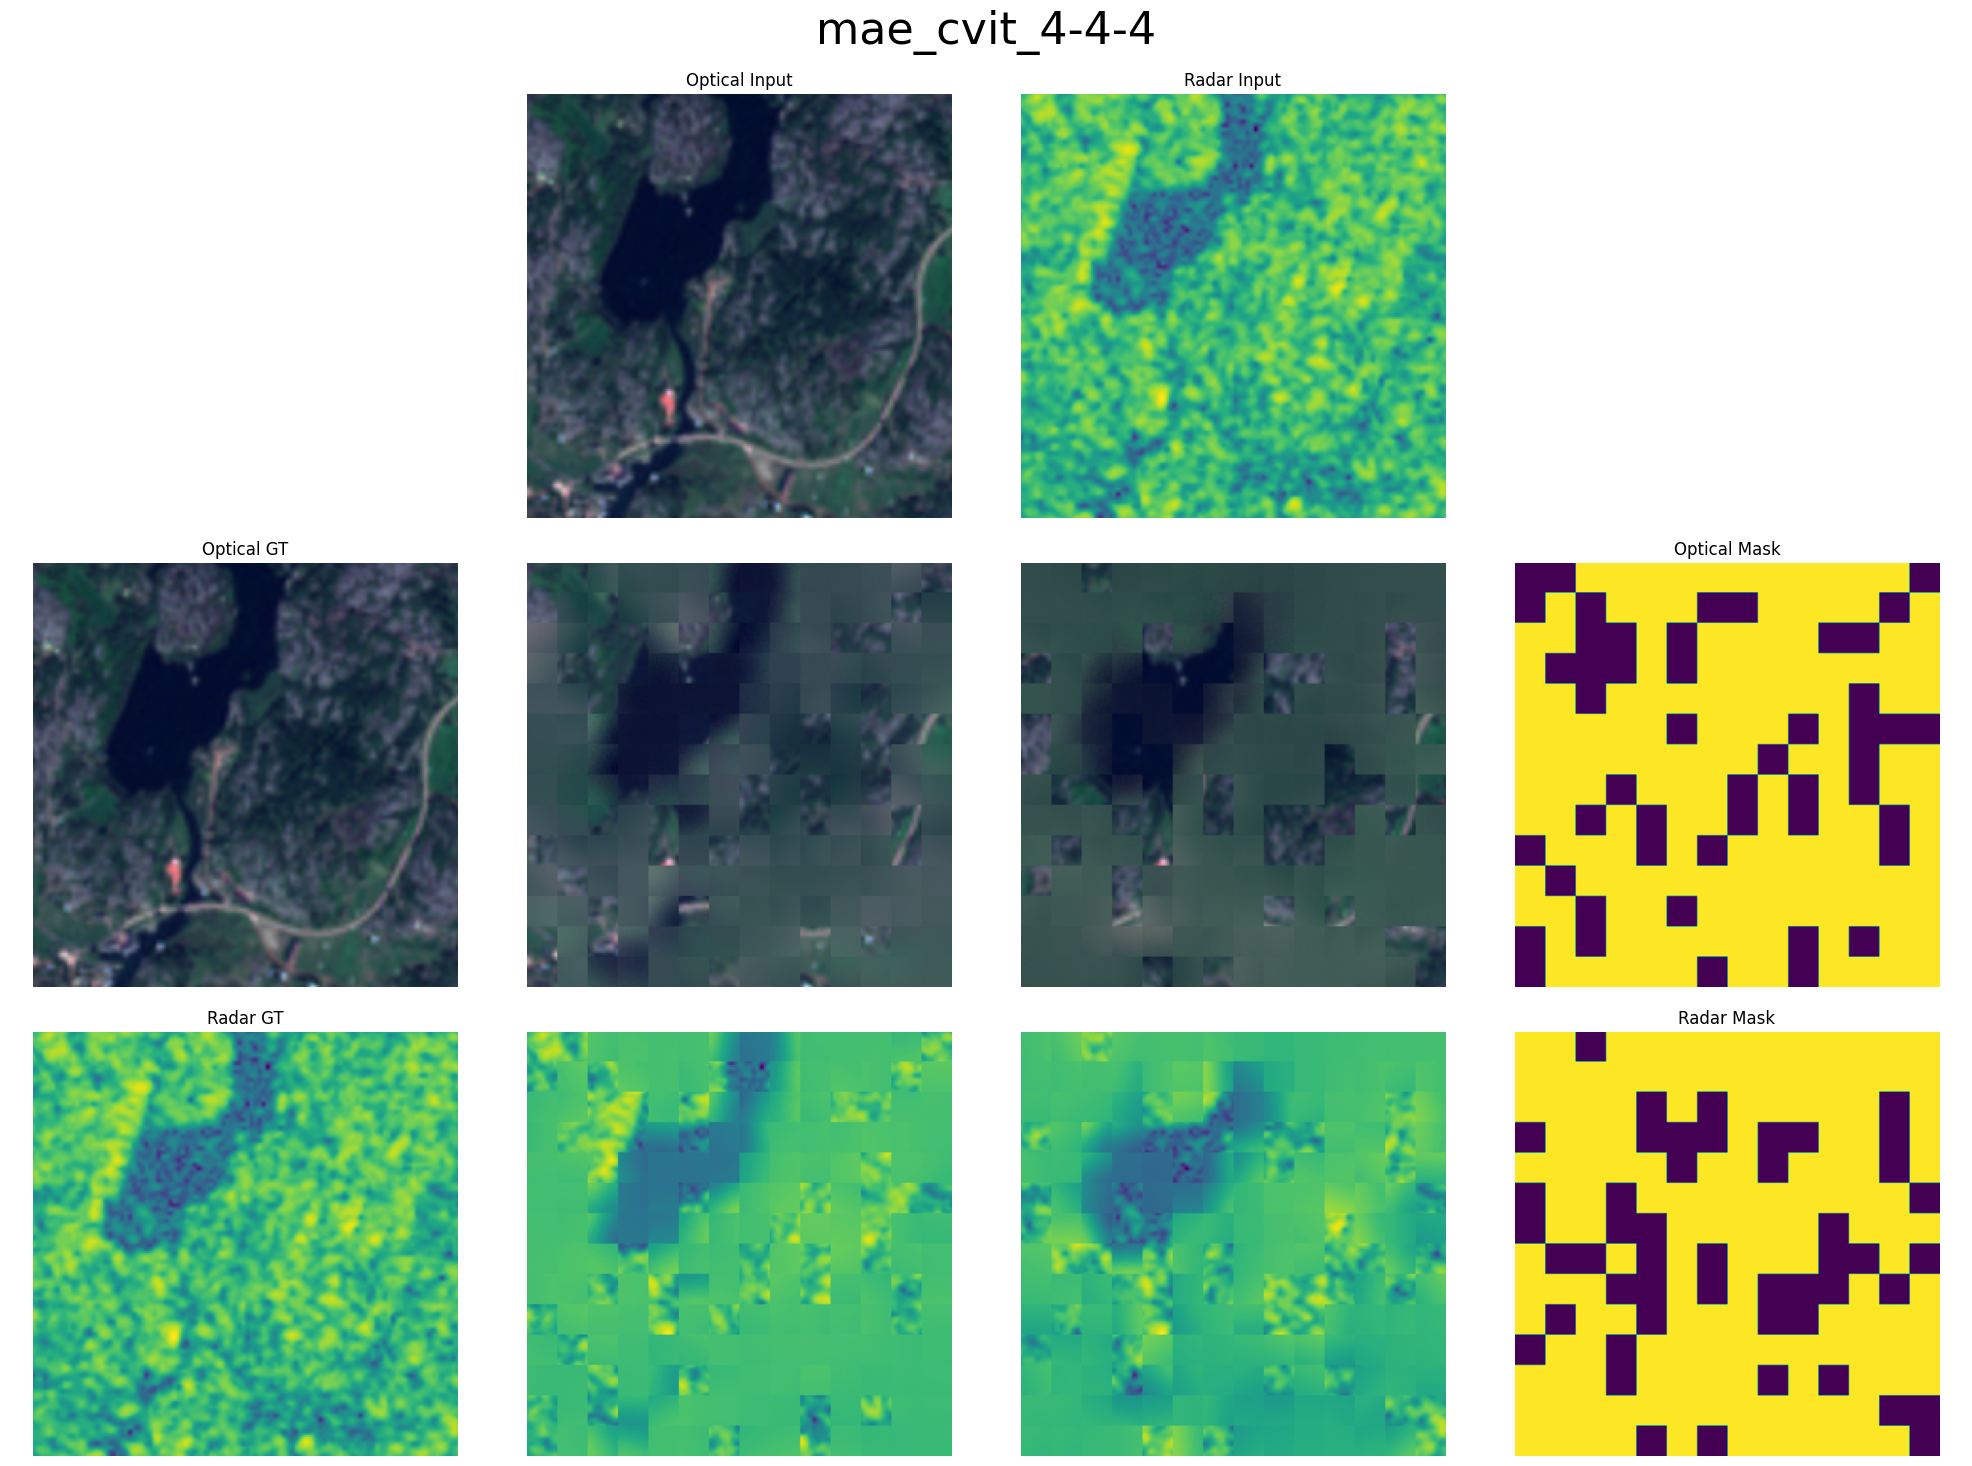

In [144]:
# plot a graph with 2x3 subplots
fig, ax = plt.subplots(3, 4, figsize=(20, 15))
# set font size
plt.rcParams.update({'font.size': 16})

ax[0, 1].imshow(vis_optical_input)
ax[0, 1].set_title('Optical Input')
ax[0, 2].imshow(vis_radar_input)
ax[0, 2].set_title('Radar Input')

ax[1, 0].imshow(vis_optical_input)
ax[1, 0].set_title('Optical GT')
ax[2, 0].imshow(vis_radar_input)
ax[2, 0].set_title('Radar GT')

ax[1, 3].imshow(vis_optical_mask)
# put the title to the right
ax[1, 3].set_title('Optical Mask')
ax[2, 3].imshow(vis_radar_mask)
ax[2, 3].set_title('Radar Mask')

if vis_optical_recon_o is not None:
    ax[1, 1].imshow(vis_optical_recon_o)
if vis_optical_recon_r is not None:
    ax[2, 1].imshow(vis_optical_recon_r)

if vis_radar_recon_o is not None:
    ax[1, 2].imshow(vis_radar_recon_o)
if vis_radar_recon_r is not None:
    ax[2, 2].imshow(vis_radar_recon_r)

# close all the ticks
for axi in ax.ravel():
    axi.axis('off')

fig.suptitle(exp_name, fontsize=32)

plt.tight_layout()

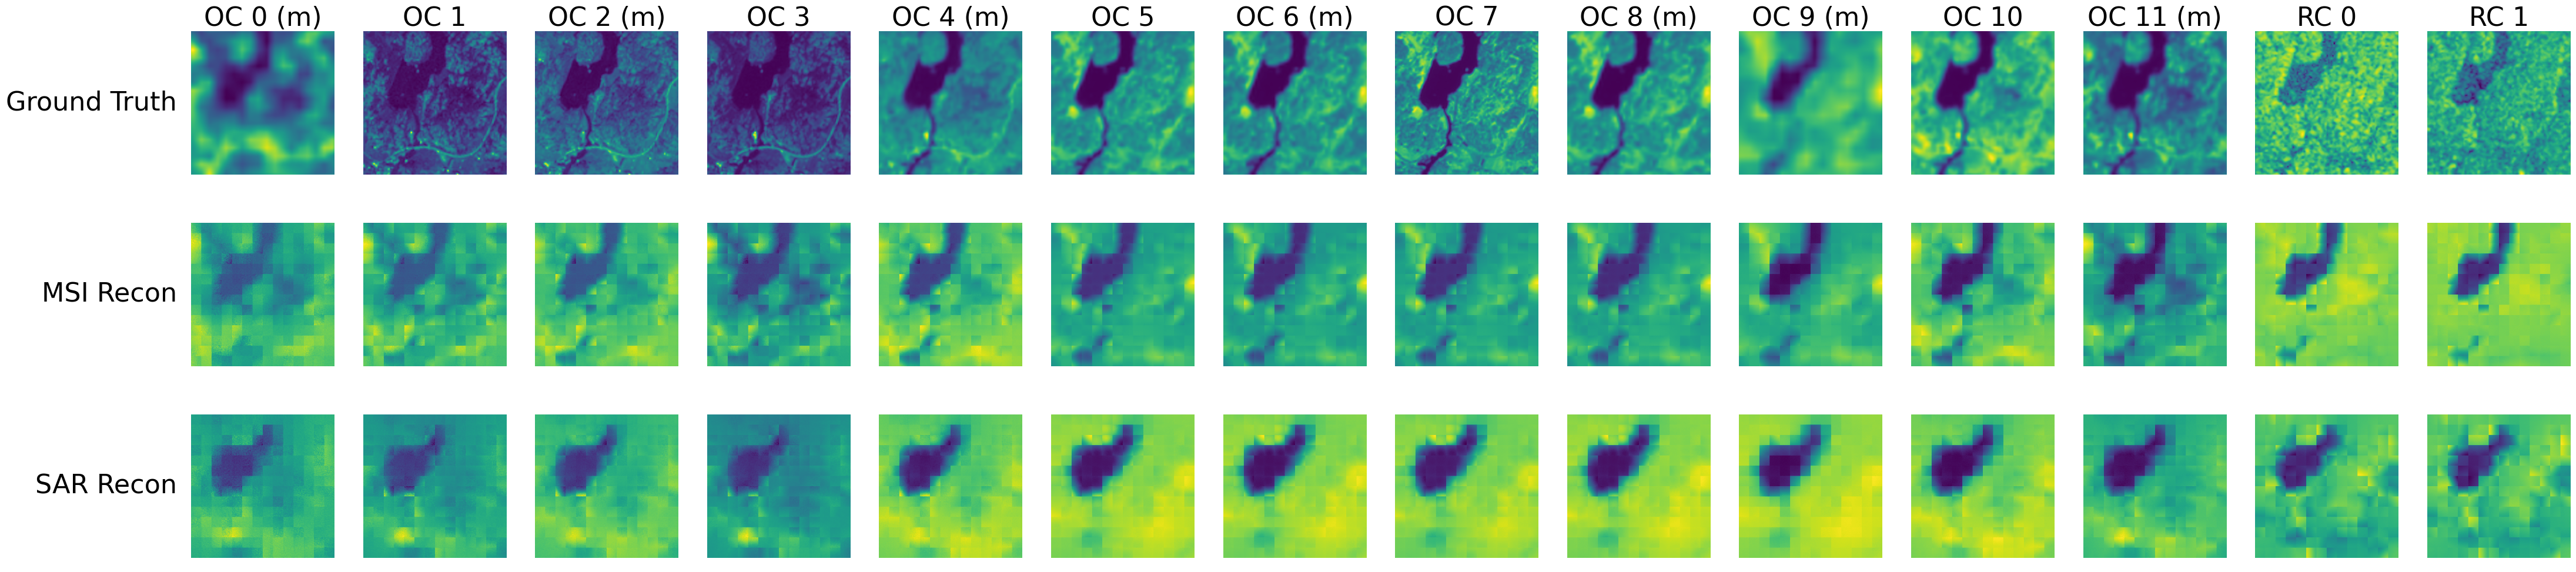

In [158]:
mpl.rcParams['axes.titlesize'] = 32

gt_all = np.concatenate([optical_input, radar_input], axis=2)
# for gt_all, optical_recon_all, radar_recon_all, pop channel 10
gt_all_ = np.delete(gt_all, 10, axis=2)
optical_recon_all_ = np.delete(optical_recon_all, 10, axis=2)
radar_recon_all_ = np.delete(radar_recon_all, 10, axis=2)
optical_channel_mask_ = np.delete(optical_channel_mask, 10, axis=0) if optical_channel_mask is not None else None
n_channels = gt_all_.shape[2]
# plot every channel optical_recon_all in a 3x5 subplot
# plt.rcParams.update({'font.size': 8})
# fig, ax = plt.subplots(3, n_channels, figsize=(17, 4))

fig = plt.figure(figsize=(56, 12)) 
gs = GridSpec(3, n_channels+1, figure=fig)

for j in range(n_channels):
    ax = fig.add_subplot(gs[0, j+1])
    ax.imshow(gt_all_[:, :, j])
    # ax[0, j].imshow(gt_all_[:, :, j])
    if j > 11:
        # ax[0, j].set_title(f'RC {j-12}')
        ax.set_title(f'RC {j-12}')
    elif optical_channel_mask_ is not None and j < len(optical_channel_mask_):
        if optical_channel_mask_[j] == 0:
            # ax[0, j].set_title(f'OC {j}')
            ax.set_title(f'OC {j}')
        else:
            # ax[0, j].set_title(f'OC {j} (m)')
            ax.set_title(f'OC {j} (m)')
    else:
        # ax[0, j].set_title(f'OC {j}')
        ax.set_title(f'OC {j}')
    # ax[0, j].axis('off')
    ax.axis('off')
for j in range(n_channels):
    ax = fig.add_subplot(gs[1, j+1])
    ax.imshow(optical_recon_all_[:, :, j])
    # ax[1, j].imshow(optical_recon_all_[:, :, j])
    # ax[1, j].set_title(f'Channel {j}')
    # ax[1, j].axis('off')
    ax.axis('off')
for j in range(n_channels):
    ax = fig.add_subplot(gs[2, j+1])
    # ax[2, j].imshow(radar_recon_all_[:, :, j])
    ax.imshow(radar_recon_all_[:, :, j])
    # ax[1, j].set_title(f'Channel {j}')
    # ax[2, j].axis('off')
    ax.axis('off')
# fig.suptitle(exp_name, fontsize=18)
row_labels = ['Ground Truth', 'MSI Recon', 'SAR Recon']  # Adjust as needed
# Set the x coordinate for the labels, this will need to be adjusted based on your layout
x_coord = 1.1

# Add the labels to the left of the first column of images
for i, label in enumerate(row_labels):
    ax = fig.add_subplot(gs[i, 0])
    ax.axis('off')  # Turn off the axis if not needed

    # Place the text relative to the current axis
    ax.text(x_coord, 0.5, label, va='center', ha='right', transform=ax.transAxes, fontsize=32)

plt.show()